In [0]:
# load file paths and constants

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


# file paths
PATH = "/content/drive/My Drive/"
file_path = "/content/drive/My Drive/book_cover_data/title30/title30cat_2.zip"
csv_path = "/content/drive/My Drive/book_cover_data/title30/book30short.csv"
cover_path = "/content/224x224/"

# constants
val_ratio = 0.1
test_ratio = 0.1
BUFFER_SIZE = 1000
BATCH_SIZE = 32
steps_train = (57000*0.8) // BATCH_SIZE
steps_val = (57000*0.1) // BATCH_SIZE
steps_test = (57000*0.1) // BATCH_SIZE
IMG_DIM = (224, 224, 3)
outdim_size = 30
vocab_size = 17997

# tfrecord file name for train, test and val
tfrecord_path = ["train_data.tfrecord", "val_data.tfrecord", "test_data.tfrecord"]

# unzip files
def unzip_data(file_path):
  from zipfile import ZipFile
  with ZipFile(file_path, "r") as zip:
    zip.extractall()
    return "Data has been extracted"

unzip_data(file_path)

2.2.0


In [0]:
# load helper function for tensorflow data pipleline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# helper functions for writing tfrecord data
def load_csv():
    """ load the data from csv file and split those into train, validation and test parts """
    df = pd.read_csv(csv_path, header = 0, index_col = 0, encoding='latin1')
    # split the data into train, validation and test
    train_data, val_data = train_test_split(df, test_size=(test_ratio+val_ratio), random_state=21)
    val_data, test_data = train_test_split(val_data, test_size=test_ratio/(test_ratio+val_ratio), random_state=21)
    return train_data, val_data, test_data


def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def make_example(image_string, label):
    feature = {
        'image_string': _bytes_feature(image_string),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecord(data, tfrecord_path):
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for _,row in data.iterrows():
            img_file = cover_path+row["file"]
            label = row["cat_id"]
            image_string = open(img_file, 'rb').read()
            example = make_example(image_string, label)  
            writer.write(example.SerializeToString())   


# healper functions for reading tfrecord data 
feature_description = {
    'image_string': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def parser(proto):
    parsed_features = tf.io.parse_single_example(proto, feature_description)
    image = parsed_features['image_string']
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_DIM[0], IMG_DIM[1]])
    label = parsed_features['label']
    return image, label

def get_dataset(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    dataset = dataset.map(parser, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    #dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def load_data(first_time=True):
    if first_time:
        data = load_csv()
        for i in range(3):
           write_tfrecord(data[i], tfrecord_path[i])

    # load the dataset    
    dataset = []   
    for i in range(3):
        data = get_dataset(tfrecord_path[i])
        dataset.append(data)
    return dataset


In [0]:
# load data
train_data, val_data, test_data = load_data(True)

In [0]:
# training function

import matplotlib.pyplot as plt

def train_model(model, epoch_num, verbose=1):

    earlystop = callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=1)
    checkpointer = callbacks.ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
  
    history = model.fit(train_data.repeat(),
                        steps_per_epoch = steps_train,
                        epochs = epoch_num,
                        validation_data= val_data.repeat(),
                        validation_steps = steps_val,
                        use_multiprocessing=True,
                        verbose=verbose,
                        callbacks=[checkpointer, earlystop])


    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    model.load_weights("temp_weights.h5")
    results = model.evaluate(val_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on validation data: ', results)

    results = model.evaluate(test_data, use_multiprocessing=True, verbose=1)
    results = dict(zip(model.metrics_names, results))
    print('Result on test data: ', results)



    return model

In [0]:
# model building with tensorflow_hub

import tensorflow_hub as hub
from tensorflow.keras import layers, applications, models, optimizers, losses, regularizers, callbacks, metrics

def get_model_name(base_model):
    model_name = base_model.split("/")
    return model_name[5].capitalize()

def create_model_hub(base_model, lr=0.001):         
    model = tf.keras.Sequential([
        hub.KerasLayer(base_model, trainable=False),
        #layers.Dense(1024, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(outdim_size, activation='softmax')
    ])
    model.build([None, IMG_DIM[0], IMG_DIM[1], IMG_DIM[2]])  # Batch input shape.

    optimizer = optimizers.Adam(learning_rate=lr)
    loss=losses.sparse_categorical_crossentropy
    #metric = ['accuracy', metrics.SparseTopKCategoricalAccuracy(3)]
    metric = ['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(3)]
    model.compile(optimizer, loss, metric)

    return model

In [0]:
#mobilenet v1 + 1024fc
model = create_model_hub("https://tfhub.dev/google/imagenet/mobilenet_v1_075_224/feature_vector/4", 0.0001)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_10 (KerasLayer)  multiple                  1832976   
_________________________________________________________________
dense_58 (Dense)             multiple                  787456    
_________________________________________________________________
dense_59 (Dense)             multiple                  30750     
Total params: 2,651,182
Trainable params: 818,206
Non-trainable params: 1,832,976
_________________________________________________________________


Epoch 1/25
1425/1425 [==============================] - ETA: 0s - loss: 2.8677 - accuracy: 0.2075 - sparse_top_k_categorical_accuracy: 0.3812
Epoch 00001: val_loss improved from inf to 2.73579, saving model to temp_weights.h5
1425/1425 [==============================] - 36s 25ms/step - loss: 2.8677 - accuracy: 0.2075 - sparse_top_k_categorical_accuracy: 0.3812 - val_loss: 2.7358 - val_accuracy: 0.2398 - val_sparse_top_k_categorical_accuracy: 0.4228
Epoch 2/25
1423/1425 [============================>.] - ETA: 0s - loss: 2.6232 - accuracy: 0.2673 - sparse_top_k_categorical_accuracy: 0.4674
Epoch 00002: val_loss improved from 2.73579 to 2.67427, saving model to temp_weights.h5
1425/1425 [==============================] - 36s 25ms/step - loss: 2.6232 - accuracy: 0.2673 - sparse_top_k_categorical_accuracy: 0.4675 - val_loss: 2.6743 - val_accuracy: 0.2563 - val_sparse_top_k_categorical_accuracy: 0.4461
Epoch 3/25
1423/1425 [============================>.] - ETA: 0s - loss: 2.5097 - accuracy:

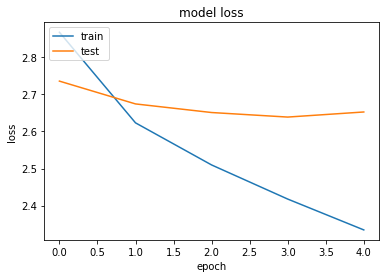

178/178 [==============================] - 4s 21ms/step - loss: 2.6386 - accuracy: 0.2639 - sparse_top_k_categorical_accuracy: 0.4598
Result on validation data:  {'loss': 2.6386446952819824, 'accuracy': 0.26386937499046326, 'sparse_top_k_categorical_accuracy': 0.45979633927345276}
178/178 [==============================] - 4s 21ms/step - loss: 2.6332 - accuracy: 0.2723 - sparse_top_k_categorical_accuracy: 0.4640
Result on test data:  {'loss': 2.6332364082336426, 'accuracy': 0.27229633927345276, 'sparse_top_k_categorical_accuracy': 0.4640098214149475}


In [0]:
train_model(model, 25)

Epoch 1/25
1425/1425 [==============================] - ETA: 0s - loss: 2.7783 - accuracy: 0.2342 - sparse_top_k_categorical_accuracy: 0.4145
Epoch 00001: val_loss improved from inf to 2.62831, saving model to temp_weights.h5
1425/1425 [==============================] - 96s 67ms/step - loss: 2.7783 - accuracy: 0.2342 - sparse_top_k_categorical_accuracy: 0.4145 - val_loss: 2.6283 - val_accuracy: 0.2733 - val_sparse_top_k_categorical_accuracy: 0.4698
Epoch 2/25
1425/1425 [==============================] - ETA: 0s - loss: 2.4621 - accuracy: 0.3080 - sparse_top_k_categorical_accuracy: 0.5179
Epoch 00002: val_loss improved from 2.62831 to 2.59195, saving model to temp_weights.h5
1425/1425 [==============================] - 95s 67ms/step - loss: 2.4621 - accuracy: 0.3080 - sparse_top_k_categorical_accuracy: 0.5179 - val_loss: 2.5920 - val_accuracy: 0.2825 - val_sparse_top_k_categorical_accuracy: 0.4802
Epoch 3/25
1425/1425 [==============================] - ETA: 0s - loss: 2.2750 - accuracy:

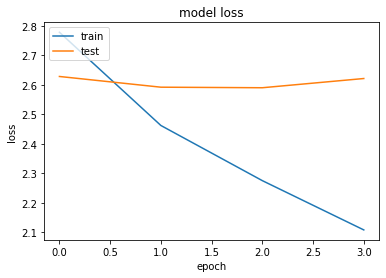

178/178 [==============================] - 10s 58ms/step - loss: 2.5896 - accuracy: 0.2874 - sparse_top_k_categorical_accuracy: 0.4810
Result on validation data:  {'loss': 2.5895776748657227, 'accuracy': 0.2873946726322174, 'sparse_top_k_categorical_accuracy': 0.4810393154621124}
178/178 [==============================] - 10s 58ms/step - loss: 2.5563 - accuracy: 0.2956 - sparse_top_k_categorical_accuracy: 0.4902
Result on test data:  {'loss': 2.5563247203826904, 'accuracy': 0.295646071434021, 'sparse_top_k_categorical_accuracy': 0.4901685416698456}


In [0]:
#resnet50
model = create_model_hub("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1", 0.0001)
train_model(model, 25)

Epoch 1/25
1425/1425 [==============================] - ETA: 0s - loss: 2.8948 - accuracy: 0.1986 - sparse_top_k_categorical_accuracy: 0.3728
Epoch 00001: val_loss improved from inf to 2.74206, saving model to temp_weights.h5
1425/1425 [==============================] - 61s 42ms/step - loss: 2.8948 - accuracy: 0.1986 - sparse_top_k_categorical_accuracy: 0.3728 - val_loss: 2.7421 - val_accuracy: 0.2367 - val_sparse_top_k_categorical_accuracy: 0.4292
Epoch 2/25
1425/1425 [==============================] - ETA: 0s - loss: 2.6851 - accuracy: 0.2510 - sparse_top_k_categorical_accuracy: 0.4462
Epoch 00002: val_loss improved from 2.74206 to 2.69327, saving model to temp_weights.h5
1425/1425 [==============================] - 60s 42ms/step - loss: 2.6851 - accuracy: 0.2510 - sparse_top_k_categorical_accuracy: 0.4462 - val_loss: 2.6933 - val_accuracy: 0.2475 - val_sparse_top_k_categorical_accuracy: 0.4489
Epoch 3/25
1425/1425 [==============================] - ETA: 0s - loss: 2.6049 - accuracy:

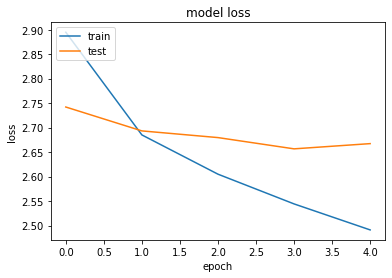

178/178 [==============================] - 7s 37ms/step - loss: 2.6567 - accuracy: 0.2575 - sparse_top_k_categorical_accuracy: 0.4491
Result on validation data:  {'loss': 2.656677007675171, 'accuracy': 0.2575491666793823, 'sparse_top_k_categorical_accuracy': 0.44908708333969116}
178/178 [==============================] - 7s 37ms/step - loss: 2.6445 - accuracy: 0.2621 - sparse_top_k_categorical_accuracy: 0.4561
Result on test data:  {'loss': 2.644482374191284, 'accuracy': 0.2621137499809265, 'sparse_top_k_categorical_accuracy': 0.45610955357551575}


In [0]:
#inception v2
model = create_model_hub("https://tfhub.dev/google/imagenet/inception_v2/feature_vector/4", 0.0001)
train_model(model, 25)